# Campaign Optimization 

As businesses are starting to acknowledge the power of data, leveraging machine learning techniques to grow has become a must. In particular, customer-oriented businesses can learn patterns from their data to intelligently design acquisition campaigns and convert the highest possible number of customers. 

Among the key variables to learn from data are the best communication channel (e.g. SMS, Email, Call), the day of the week and the time of the day through which/ during which a given potential customer is targeted by a marketing campaign. This template provides a customer-oriented business with an analytics tool that helps determine the best combination of these three variables for each customer, based (among others) on financial and demographic data.

This notebook takes advantage of the power of SQL Server and RevoScaleR (Microsoft R Server). The tables are all stored in a SQL Server, and most of the computations are done without loading data in-memory.

It does the following: 

 * **Step 0: Packages and Compute Contexts**
 * **Step 1: Pre-Processing and Cleaning**
 * **Step 2: Feature Engineering**
 * **Step 3: Training and Evalutating the Models**
 * **Step 4: Channel-Day-Time Recommendations**

## Step 0: Packages and Compute Contexts

#### In this step, we set up the connection string to access a SQL Server Database and load the necessary library. 

In [1]:
# WARNING.
# We recommend not using Internet Explorer as it does not support plotting, and may crash your session.

In [2]:
# Check that the required libraries are installed
if (!('RODBC' %in% rownames(installed.packages()))){
  install.packages('RODBC', lib='./libsforjupyter')
}
if (!('ggplot2' %in% rownames(installed.packages()))){
  install.packages('ggplot2', lib='./libsforjupyter')
}
if (!('reshape' %in% rownames(installed.packages()))){
  install.packages('reshape', lib='./libsforjupyter')
}
if (!('scales' %in% rownames(installed.packages()))){
  install.packages('reshape', lib='./libsforjupyter')
}

# Load packages.
library(RevoScaleR)
library(RODBC)
library(ggplot2)
library(reshape)
library(scales)

In [7]:
# Choose a database name and create it. 
db <- "Campaign"

## Connect to the master database only to create a new database. Change UID and PWD if you modified them. 
connection_string <- "Driver=SQL Server;Server=localhost;Database=master;UID=rdemo;PWD=D@tascience"

## Open a connection with SQL Server to be able to write queries with the rxExecuteSQLDDL function.
outOdbcDS <- RxOdbcData(table = "NewData", connectionString = connection_string, useFastRead=TRUE)
rxOpen(outOdbcDS, "w")

query <- sprintf( "if not exists(SELECT * FROM sys.databases WHERE name = '%s') CREATE DATABASE %s;", db, db)

## Create database. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = query)

[1] TRUE

[1] TRUE

In [8]:
# Define Compute Contexts: user to input Server Name, database name, User ID and Password. 
connection_string <- sprintf("Driver=SQL Server;Server=localhost;Database=%s;UID=rdemo;PWD=D@tascience", db)
sql <- RxInSqlServer(connectionString = connection_string)
local <- RxLocalSeq()

#### The function below can be used to get the top n rows of a table stored on SQL Server. 
#### You can execute this cell throughout your progress by removing the comment "#", and inputting:
#### - the table name.
#### - the number of rows you want to display.

In [9]:
 display_head <- function(table_name, n_rows){
   table_sql <- RxSqlServerData(sqlQuery = sprintf("SELECT TOP(%s) * FROM %s", n_rows, table_name), connectionString = connection_string)
   table <- rxImport(table_sql)
   print(table)
}

# table_name <- "insert_table_name"
# n_rows <- 10
# display_head(table_name, n_rows)

## Step 1: Pre-Processing and Cleaning

In this step, we: 

**1.** Read  Campaign_Detail, Lead_Demography, Market_Touchdown, and Product, and load them into SQL.

**2.** Join the 4 tables into one.

**3.** Clean the merged data set: replace NAs with the mode.

#### Description of the 4 raw data sets: 

<table style="width:85%">
  <tr>
    <th>File</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Campaign_Detail.csv</td>
    <td>Raw data about each marketing campaign that occurred</td>
  </tr>
  <tr>
    <td>Lead_Demography.csv</td>
    <td>Raw demographics and financial data about each customer</td>
  </tr>
  <tr>
    <td>Market_Touchdown.csv</td>
    <td>Raw channel-day-time data used for every customer of Lead_Demography in every campaign he was targeted</td>
  </tr>
  <tr>
    <td>Product.csv</td>
    <td>Raw data about the product marketed in each campaign</td>
  </tr>
</table>

**Input:**  4 Data Tables: Campaign_Detail, Lead_Demography, Market-Touchdown, and Product.

**Output:** Cleaned raw data set CM_AD0.

In [10]:
# Load the 4 raw data sets in-memory from CSV files. Use the path in read.csv if data not loaded into Jupyter folder.
# path = "C:/Users/dsvmuser/Desktop/Campaign/Data/"
table_Campaign_Detail <- read.csv( "Campaign_Detail.csv")
table_Lead_Demography <- read.csv("Lead_Demography.csv")
table_Market_Touchdown <- read.csv("Market_Touchdown.csv")
table_Product <- read.csv("Product.csv")

print("Data read in-memory")

[1] "Data read in-memory"


In [11]:
# Export the 4 raw tables to the SQL Server. Compute Context should be set to local.
rxSetComputeContext(local)

Campaign_Detail <- RxSqlServerData(table = "Campaign_Detail", connectionString = connection_string)
rxDataStep(inData = table_Campaign_Detail, outFile = Campaign_Detail, overwrite = TRUE)

Lead_Demography <- RxSqlServerData(table = "Lead_Demography", connectionString = connection_string)
rxDataStep(inData = table_Lead_Demography, outFile = Lead_Demography, overwrite = TRUE)
  
Market_Touchdown <- RxSqlServerData(table = "Market_Touchdown", connectionString = connection_string)
rxDataStep(inData = table_Market_Touchdown, outFile = Market_Touchdown, overwrite = TRUE)

Product <- RxSqlServerData(table = "Product",connectionString = connection_string)
rxDataStep(inData = table_Product, outFile = Product, overwrite = TRUE)

print("Data exported to SQL")

Rows Read: 6, Total Rows Processed: 6
Total Rows written: 6, Total time: 0.016
, Total Chunk Time: 0.157 seconds 
Rows Read: 100000, Total Rows Processed: 100000
Total Rows written: 100000, Total time: 6.25
, Total Chunk Time: 6.625 seconds 
Rows Read: 500263, Total Rows Processed: 500263
Total Rows written: 100000, Total time: 4
Total Rows written: 200000, Total time: 8.125
Total Rows written: 300000, Total time: 12.187
Total Rows written: 400000, Total time: 16.312
Total Rows written: 500000, Total time: 20.375
Total Rows written: 500263, Total time: 20.422
, Total Chunk Time: 20.688 seconds 
Rows Read: 6, Total Rows Processed: 6
Total Rows written: 6, Total time: 0
, Total Chunk Time: 0.047 seconds 
[1] "Data exported to SQL"


In [12]:
# Merge the 4 data sets into one with 3 inner joins on key variables.

## Open a connection with SQL Server to be able to write queries with the rxExecuteSQLDDL function.
outOdbcDS <- RxOdbcData(table = "NewData", connectionString = connection_string, useFastRead=TRUE)
rxOpen(outOdbcDS, "w")

## Inner join of the tables Product and Campaign_Detail
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Campaign_Product;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "SELECT Campaign_Detail.*, Term , No_Of_People_Covered, 
          Payment_Frequency, Net_Amt_Insured, Amt_On_Maturity_Bin,
          Product, Premium
  INTO Campaign_Product
  FROM Campaign_Detail JOIN Product
  ON Product.Product_Id = Campaign_Detail.Product_Id;"
  , sep=""))

## Inner join of the tables Market_Touchdown and Lead_Demography
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Market_Lead;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Demography.Lead_Id, Age, Phone_No, Annual_Income_Bucket, Credit_Score, Country, State,
        No_Of_Dependents, Highest_Education, Ethnicity,
        No_Of_Children, Household_Size, Gender, 
        Marital_Status, Channel, Time_Of_Day, Conversion_Flag, Campaign_Id, Day_Of_Week, Comm_Id, Time_Stamp
 INTO Market_Lead
 FROM Market_Touchdown JOIN Lead_Demography
 ON Market_Touchdown.Lead_Id = Lead_Demography.Lead_Id;"
, sep=""))

## Point to an inner join of the two previous tables. This table will not be materialized. It is created on the fly when removing NAs. 
## Numeric variables are converted to characters only to get their mode for NA cleaning. 

Merged_sql <- RxSqlServerData(  
  sqlQuery = 
"SELECT Lead_Id, Age, Phone_No, Annual_Income_Bucket, Credit_Score, Country, State,
        CAST(No_Of_Dependents AS char(1)) AS No_Of_Dependents, Highest_Education, Ethnicity,
        CAST(No_Of_Children AS char(1)) AS No_Of_Children, CAST(Household_Size AS char(1)) AS Household_Size, Gender, 
        Marital_Status, Channel, Time_Of_Day, Conversion_Flag, Market_Lead.Campaign_Id, Day_Of_Week, Comm_Id, Time_Stamp,
        Product, Category, Term, CAST(No_Of_People_Covered AS char(1)) AS No_Of_People_Covered,
        CAST(Premium AS varchar(4)) AS Premium, Payment_Frequency,
        Amt_On_Maturity_Bin, Sub_Category, Campaign_Drivers, Campaign_Name, Launch_Date, Call_For_Action, 
        Focused_Geography, Tenure_Of_Campaign, CAST(Net_Amt_Insured AS varchar(7)) AS Net_Amt_Insured , Product_Id
 FROM Campaign_Product JOIN Market_Lead 
 ON Campaign_Product.Campaign_Id = Market_Lead.Campaign_Id "
  ,connectionString = connection_string, stringsAsFactors = TRUE)

print("Datasets merged")

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "Datasets merged"


In [13]:
# Clean the Merged data set: replace NAs with the mode

## Assumption: 
## no NAs in the Id variables (Lead_Id, Product_Id, Campaign_Id, Comm_Id) and in (Phone_No, Launch_Date, Time_Stamp).

## Find the variables that have missing values (NA). 
colnames <- names(rxGetVarInfo(Merged_sql))
var <- colnames[!colnames %in% c("Lead_Id", "Product_Id", "Campaign_Id", "Comm_Id", "Phone_No", "Launch_Date", "Time_Stamp")]
formula <- as.formula(paste("~", paste(var, collapse = "+")))
summary <- rxSummary(formula, Merged_sql, byTerm = TRUE)
var_with_NA <- summary$sDataFrame[summary$sDataFrame$MissingObs > 0, 1] 
var_number_with_NA <- which(summary$sDataFrame$MissingObs > 0) 

## Compute the mode of variables with missing values. 
mode <- c()
k <- 0
for(n in var_number_with_NA ){
  k <- k + 1
  mode[k] <- as.character(summary$categorical[[n]][which.max(summary$categorical[[n]][,2]),1])
}

## Point again to the merged table without stringsAsFactors = TRUE and with correct variable types. 
Merged_sql2 <- RxSqlServerData(  
  sqlQuery = 
"SELECT Market_Lead.*, Product, Category, Term, No_Of_People_Covered, Premium, Payment_Frequency,
        Amt_On_Maturity_Bin, Sub_Category, Campaign_Drivers, Campaign_Name, Launch_Date, Call_For_Action, 
        Focused_Geography, Tenure_Of_Campaign, Net_Amt_Insured, Product_Id
 FROM Campaign_Product JOIN Market_Lead
 ON Campaign_Product.Campaign_Id = Market_Lead.Campaign_Id "
  ,connectionString = connection_string)

## Function to deal with NAs. 
Mode_Replace <- function(data) {
  data <- data.frame(data)
  for(j in 1:length(var_with_NA_1)){
    row_na <- which(is.na(data[,var_with_NA_1[j]]) == TRUE) 
        if (var_with_NA_1[j] %in% c("No_Of_Dependents", "No_Of_Children", "Household_Size", "No_Of_People_Covered", "Premium", "Net_Amt_Insured")){
          data[row_na,var_with_NA_1[j]] <- as.integer(mode_1[j])
        } else{
          data[row_na,var_with_NA_1[j]] <- mode_1[j]
        }
  }
  return(data)
}

## Create the CM_AD0 table by dealing with NAs in Merged_sql and save it to a SQL table.
CM_AD0 <- RxSqlServerData(table = "CM_AD0", connectionString = connection_string)
rxDataStep(inData = Merged_sql2 , outFile = CM_AD0, overwrite = TRUE, transformFunc = Mode_Replace, 
           transformObjects = list(var_with_NA_1 = var_with_NA, mode_1 = mode))

## Drop intermediate tables.
rxSqlServerDropTable(table = "Campaign_Product", connectionString = connection_string)
rxSqlServerDropTable(table = "Market_Lead", connectionString = connection_string)

print("Data cleaned")

Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 2.032 seconds
Rows Read: 50000, Total Rows Processed: 100000, Total Chunk Time: 2.000 seconds
Rows Read: 50000, Total Rows Processed: 150000, Total Chunk Time: 2.000 seconds
Rows Read: 50000, Total Rows Processed: 200000, Total Chunk Time: 1.968 seconds
Rows Read: 50000, Total Rows Processed: 250000, Total Chunk Time: 1.954 seconds
Rows Read: 50000, Total Rows Processed: 300000, Total Chunk Time: 2.015 seconds
Rows Read: 50000, Total Rows Processed: 350000, Total Chunk Time: 1.984 seconds
Rows Read: 50000, Total Rows Processed: 400000, Total Chunk Time: 1.969 seconds
Rows Read: 50000, Total Rows Processed: 450000, Total Chunk Time: 2.000 seconds
Rows Read: 50000, Total Rows Processed: 500000, Total Chunk Time: 1.985 seconds
Rows Read: 263, Total Rows Processed: 500263, Total Chunk Time: 0.125 seconds 

Elapsed time to compute low/high values and/or factor levels: 20.078 secs.
 
Rows Read: 50000, Total Rows Processed: 5000

[1] TRUE

[1] TRUE

[1] "Data cleaned"


## Step 2: Feature Engineering

In this step, we:

**1.** Create SMS_Count, Email_Count, and Call_Count: number of communications through each channel. 

**2.** Create Previous_Channel: the previous channel used towards the Lead_Id in the campaign.

**3.** Aggregate the data by Lead_Id, keeping the latest campaign activity each Lead_Id received. 

**Input:** Data set with all the campaign activities received by each Lead_Id, CM_AD0.

**Output:** Data set with new features and the latest campaign activity each Lead_Id received, CM_AD.

In [14]:
# SMS_Count, Email_Count, and Call_Count
# Determine how many times each Lead_Id was contacted through SMS, Email and Call

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Intermediate;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Id, 
        coalesce(count(case when Channel = 'SMS' then 1 end), 0) as SMS_Count,
        coalesce(count(case when Channel = 'Cold Calling' then 1 end), 0) as Call_Count,
        coalesce(count(case when Channel = 'Email' then 1 end), 0) as Email_Count
 INTO Intermediate
 FROM CM_AD0
 GROUP BY Lead_Id;"
, sep=""))

print("Counts computed")

[1] TRUE

[1] TRUE

[1] "Counts computed"


In [15]:
# Previous_Channel
# Determine the previous channel used towards every Lead_Id for every campaign activity 
# The first record for each Lead_Id will be disregarded. 

## Create a lag variable corresponding to the previous channel, while performing an inner join to append the Counts. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Intermediate2;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT CM_AD0.*, Intermediate.SMS_Count, Intermediate.Email_Count, Intermediate.Call_Count, 
        LAG(Channel, 1,0) OVER (Partition by CM_AD0.Lead_Id ORDER BY CM_AD0.Lead_Id, Comm_Id ASC) AS Previous_Channel,
        ROW_NUMBER() OVER (PARTITION BY CM_AD0.Lead_Id ORDER BY CM_AD0.Comm_Id DESC) AS Row
 INTO Intermediate2
 FROM Intermediate JOIN CM_AD0 
 ON Intermediate.Lead_Id = CM_AD0.Lead_Id ;"
, sep=""))

print("Previous_Channel computed")

[1] TRUE

[1] TRUE

[1] "Previous_Channel computed"


In [16]:
# CM_AD is the data set that will be used for modeling. 
# In order to ensure coherence between the SQL SP code and the R code, we specify here the types of the variables in CM_AD. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists CM_AD;", sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("CREATE TABLE CM_AD
(
  Lead_Id varchar(15) NOT NULL Primary Key
  ,Age varchar(30)
  ,Phone_No varchar(50)
  ,Annual_Income_Bucket varchar(15)
  ,Credit_Score  varchar(15)
  ,Country varchar(5)
  ,[State] char(2)
  ,No_Of_Dependents int
  ,Highest_Education varchar(30) 
  ,Ethnicity varchar(20)
  ,No_Of_Children int 
  ,Household_Size int 
  ,Gender char(1)
  ,Marital_Status char(1)
  ,Channel varchar(15)
  ,Time_Of_Day varchar(15)
  ,Conversion_Flag char(1)
  ,Campaign_Id char(1)
  ,Day_Of_Week char(1)
  ,Comm_Id char(1)
  ,Time_Stamp date
  ,Product varchar(50)
  ,Category varchar(15)
  ,Term char(2)
  ,No_Of_People_Covered int
  ,Premium int 
  ,Payment_Frequency varchar(50)
  ,Amt_On_Maturity_Bin varchar(50)
  ,Sub_Category varchar(15)
  ,Campaign_Drivers varchar(50)
  ,Campaign_Name varchar(50)
  ,Launch_Date date
  ,Call_For_Action char(1)
  ,Focused_Geography varchar(15)
  ,Tenure_Of_Campaign char(1)
  ,Net_Amt_Insured int
  ,Product_Id char(1)
  ,SMS_Count int
  ,Email_Count int
  ,Call_Count int 
  ,Previous_Channel varchar(15)
  ,[Row] int
);"
, sep=""))


# Keeping the last record for each Lead_Id. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"INSERT INTO CM_AD
 SELECT *  
 FROM Intermediate2
 WHERE Row = 1  ;"
  , sep=""))

# Removing the Row number variables. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("ALTER TABLE CM_AD DROP COLUMN Row;", sep=""))

print("Aggregation done")

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "Aggregation done"


In [17]:
# Drop intermediate tables. 
rxSqlServerDropTable(table = "Intermediate", connectionString = connection_string)
rxSqlServerDropTable(table = "Intermediate2", connectionString = connection_string)

[1] TRUE

[1] TRUE

## Step 3: Training and Evaluating the Models

In this step we:

**1.** Split CM_AD into a Training CM_AD_Train, and a Testing set CM_AD_Test.  

**2.** Train Random Forest (RF) and Gradient Boosting Trees (GBT) on CM_AD_Train, and save them to SQL. 

**3.** Score RF and GBT on CM_AD_Test.

**4.** Select the best model based on AUC. 

**Input:** Data set CM_AD.

**Output:** Random forest and GBT models saved to SQL. One of them is chosen based on AUC. 

In [18]:
# Point to the SQL table with the data set for modeling. Strings will be converted to factors.
CM_AD <- RxSqlServerData(table = "CM_AD", connectionString = connection_string, stringsAsFactors = T)

In [19]:
# Get variable names, types, and levels for factors.
column_info <- rxCreateColInfo(CM_AD)

print("Column information received")

[1] "Column information received"


In [20]:
# Randomly split the data into a training set and a testing set, with a splitting % p.
# p % goes to the training set, and the rest goes to the testing set. Default is 70%. 

p <- "70" 

## Create the Train_Id table containing Lead_Id of training set. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Train_Id;", sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = sprintf(
  "SELECT Lead_Id
   INTO Train_Id
   FROM CM_AD
   WHERE ABS(CAST(BINARY_CHECKSUM(Lead_ID, NEWID()) as int)) %s < %s ;"
  ,"% 100", p ))

## Point to the training set. It will be created on the fly when training models. 
CM_AD_Train <- RxSqlServerData(  
  sqlQuery = "SELECT *   
              FROM CM_AD 
              WHERE Lead_Id IN (SELECT Lead_Id from Train_Id)",
  connectionString = connection_string, colInfo = column_info)

## Point to the testing set. It will be created on the fly when testing models. 
CM_AD_Test <- RxSqlServerData(  
  sqlQuery = "SELECT *   
              FROM CM_AD 
              WHERE Lead_Id NOT IN (SELECT Lead_Id from Train_Id)",
  connectionString = connection_string, colInfo = column_info)


print("Splitting completed")

[1] TRUE

[1] TRUE

[1] "Splitting completed"


In [21]:
# Specify the variables to keep for the training by writing the formula.

variables_all <- rxGetVarNames(CM_AD_Train)
variables_to_remove <- c("Lead_Id", "Phone_No", "Country", "Comm_Id", "Time_Stamp", "Category", "Launch_Date", "Focused_Geography",
                         "Call_For_Action", "Product", "Campaign_Name")
traning_variables <- variables_all[!(variables_all %in% c("Conversion_Flag", variables_to_remove))]
formula <- as.formula(paste("Conversion_Flag ~", paste(traning_variables, collapse = "+")))


In [22]:
# Compute Context is set to SQL for model training.
rxSetComputeContext(sql)

In [23]:
# Random Forest Training.
forest_model <- rxDForest(formula = formula,
                          data = CM_AD_Train,
                          nTree = 40,
                          minSplit = 10,
                          minBucket = 5,
                          cp = 0.00005,
                          seed = 5)

print("Training RF done")

[1] "Training RF done"


In [24]:
# Gradient Boosted Trees Training
btree_model <- rxBTrees(formula = formula,
                        data = CM_AD_Train,
                        learningRate = 0.05,
                        minSplit = 10,
                        minBucket = 5,
                        cp = 0.0005,
                        nTree = 40,
                        seed = 5,
                        lossFunction = "multinomial")

print("Training GBT done")

[1] "Training GBT done"


In [25]:
# Compute Context is set to local for model testing.
rxSetComputeContext(local)

In [26]:
# Binary classification model evaluation metrics

## Write a function that computes the AUC, Accuracy, Precision, Recall, and F-Score.
evaluate_model <- function(observed, predicted_probability, threshold, model_name) { 
  
  # Given the observed labels and the predicted probability, plot the ROC curve and determine the AUC.

  data <- data.frame(observed, predicted_probability)
  data$observed <- as.numeric(as.character(data$observed))
  if(model_name =="RF"){
  rxRocCurve(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000, title = "RF" )
  }else{
  rxRocCurve(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000, title = "GBT")
    }
  ROC <- rxRoc(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000)
  auc <- rxAuc(ROC)
  
  # Given the predicted probability and the threshold, determine the binary prediction.
  predicted <- ifelse(predicted_probability > threshold, 1, 0) 
  predicted <- factor(predicted, levels = c(0, 1)) 
  
  # Build the corresponding Confusion Matrix, then compute the Accuracy, Precision, Recall, and F-Score.
  confusion <- table(observed, predicted)
  print(model_name)
  print(confusion) 
  tp <- confusion[1, 1] 
  fn <- confusion[1, 2] 
  fp <- confusion[2, 1] 
  tn <- confusion[2, 2] 
  accuracy <- (tp + tn) / (tp + fn + fp + tn) 
  precision <- tp / (tp + fp) 
  recall <- tp / (tp + fn) 
  fscore <- 2 * (precision * recall) / (precision + recall) 
  
  # Return the computed metrics.
  metrics <- list("Accuracy" = accuracy, 
                  "Precision" = precision, 
                  "Recall" = recall, 
                  "F-Score" = fscore,
                  "AUC" = auc) 
  return(metrics) 
} 

Rows Read: 29976, Total Rows Processed: 29976, Total Chunk Time: 1.015 seconds
Total Rows written: 29976, Total time: 0.844
 
Rows Read: 29976, Total Rows Processed: 29976, Total Chunk Time: 0.125 seconds 
[1] "RF"
        predicted
observed     0     1
       0 14872 12114
       1   116  2874
[1] "Scoring RF done"


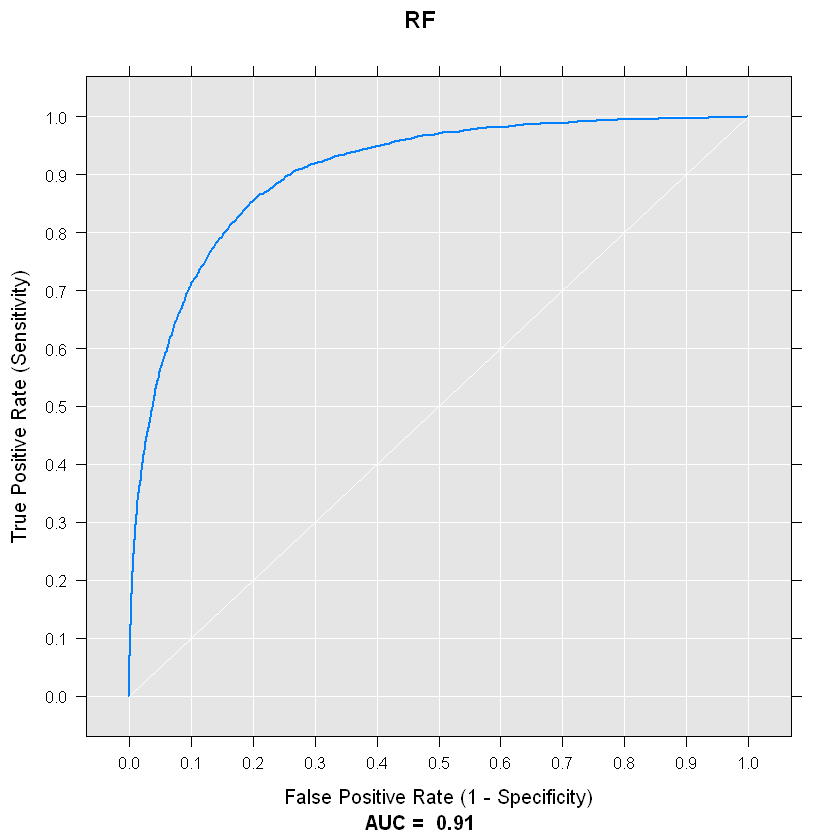

In [27]:
# Random Forest Scoring

## Make Predictions, then import them into R. The observed Conversion_Flag is kept through extraVarsToWrite.
Prediction_Table_RF <- RxSqlServerData(table = "forest_prediction", stringsAsFactors = T, 
                                       connectionString = connection_string)
rxPredict(forest_model, data = CM_AD_Test, outData = Prediction_Table_RF, overwrite = T, type = "prob",
          extraVarsToWrite = c("Conversion_Flag"))
Prediction_RF <- rxImport(inData = Prediction_Table_RF, stringsAsFactors = T, outFile = NULL)
observed <- Prediction_RF$Conversion_Flag

## Assign the decision threshold to the median of the predicted probabilities.
threshold <- median(Prediction_RF$`1_prob`)

## Compute the performance metrics of the model. 
Metrics_RF <- evaluate_model(observed = observed, predicted_probability = Prediction_RF$`1_prob`,threshold = threshold,
                             model_name = "RF")

print("Scoring RF done")

Rows Read: 29976, Total Rows Processed: 29976, Total Chunk Time: 0.750 seconds
Total Rows written: 29976, Total time: 0.844
 
Rows Read: 29976, Total Rows Processed: 29976, Total Chunk Time: 0.094 seconds 
[1] "GBT"
        predicted
observed     0     1
       0 14617 12369
       1   399  2591
[1] "Scoring GBT done"


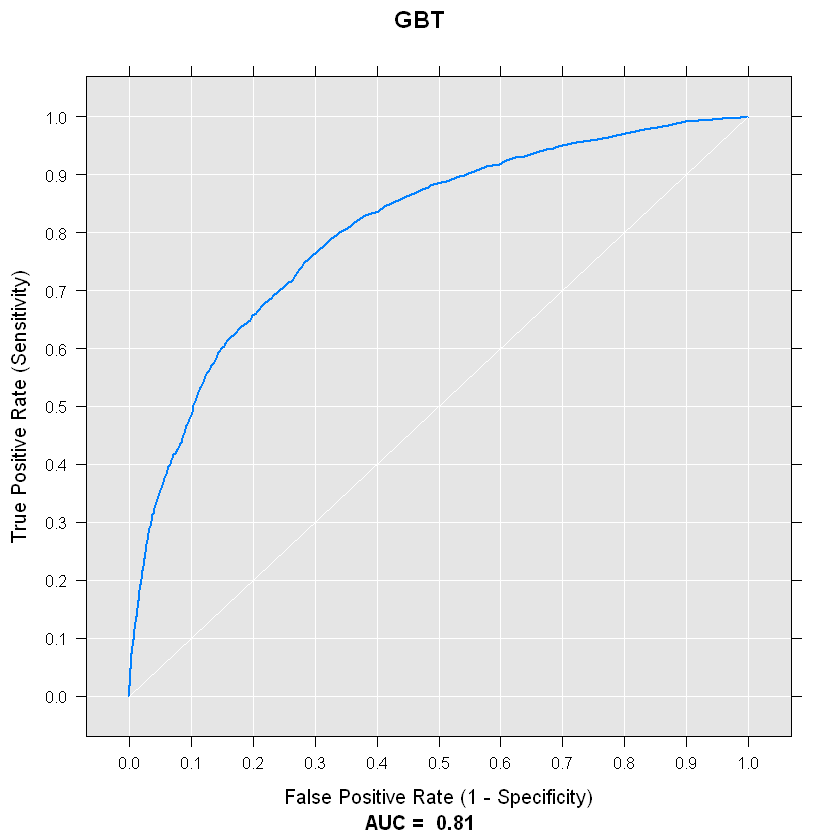

In [28]:
# Gradient Boosted Trees Scoring 

## Make Predictions, then import them into R. The observed Conversion_Flag is kept through extraVarsToWrite.
Prediction_Table_GBT <- RxSqlServerData(table = "boosted_prediction", stringsAsFactors = T, 
                                        connectionString = connection_string)

rxPredict(btree_model,data = CM_AD_Test, outData = Prediction_Table_GBT, overwrite = T, type = "prob",
          extraVarsToWrite = c("Conversion_Flag"))
Prediction_GBT <- rxImport(inData = Prediction_Table_GBT, stringsAsFactors = T, outFile = NULL)
observed <- Prediction_GBT$Conversion_Flag

## Assign the decision threshold to the median of the predicted probabilities.
threshold <- median(Prediction_GBT$`1_prob`)

## Compute the performance metrics of the model. 
Metrics_GBT <- evaluate_model(observed = observed, predicted_probability = Prediction_GBT$`1_prob`,
                              threshold = threshold, model_name = "GBT")

print("Scoring GBT done")

In [29]:
# Select the best model based on AUC
if(Metrics_RF$AUC >= Metrics_GBT$AUC){
    best <- "RF"
    best_model <- forest_model
} else {
    best <- "GBT"
    best_model <- btree_model
}

print(best)

[1] "RF"


## Step 4: Channel-Day-Time Recommendations

We determine recommendations for each Lead_Id:  best combination of Day, Channel, and Time to target him.
The best combination is the one with the highest probability of conversion given by the selected model.
This will help the business acheive a higher conversion rate.

In this step we:

**1.** Create a full data table with  all the unique combinations of Day_Of_Week, Channel, Time_Of_Day. 

**2.** Get the predicted probabilities for each Lead_Id, for all combinations of Day_Of_Week, Channel, Time_Of_Day, with best_model.

**3.** For each Lead_Id, choose the combination that has the highest conversion probability.

**Input** : Data set CM_AD and the best prediction model, best_model. 

**Output**: Recommended Day_Of_Week, Channel and Time_Of_Day for each Lead_Id.

In [30]:
# Create a full data table with all the unique combinations of Day_of_Week, Channel, Time_Of_Day 

## Create a table with all the unique combinations of Day_of_Week, Channel, Time_Of_Day.
Day_of_Week_unique <- data.frame(seq(1, 7))
Channel_unique <- data.frame(c("Email", "Cold Calling", "SMS"))
Time_Of_Day_unique <- data.frame(c("Morning", "Afternoon", "Evening"))
Unique_Combos <- merge(merge(Day_of_Week_unique, Channel_unique), Time_Of_Day_unique)
colnames(Unique_Combos) <- c("Day_Of_Week", "Channel", "Time_Of_Day")

## Export it to SQL
Unique_Combos_sql <- RxSqlServerData(table = "Unique_Combos", connectionString = connection_string)
rxDataStep(inData = Unique_Combos, outFile = Unique_Combos_sql, overwrite = T)

## We create a table that has, for each Lead_Id and its corresponding variables (except Day_of_Week, Channel, Time_Of_Day),
## One row for each possible combination of Day_of_Week, Channel and Time_Of_Day.
## This is a pointer. The table will be created on the fly while scoring. 
## For a faster computation, we are considering only the top 10000 customers. 
## For the full solution, you can remove TOP(10000) in the query below. 

AD_full_merged_sql <- RxSqlServerData(
  sqlQuery = "SELECT * 
              FROM (
                    SELECT TOP(10000) Lead_Id, Age, Annual_Income_Bucket, Credit_Score, State, No_Of_Dependents, Highest_Education, Ethnicity,
                    No_Of_Children, Household_Size, Gender, Marital_Status, Campaign_Id, Product_Id, Term,
                    No_Of_People_Covered, Premium, Payment_Frequency, Amt_On_Maturity_Bin, Sub_Category, Campaign_Drivers,
                    Tenure_Of_Campaign, Net_Amt_Insured, SMS_Count, Email_Count,  Call_Count, 
                    Previous_Channel, Conversion_Flag
                    FROM CM_AD) a,
                    (SELECT * FROM Unique_Combos) b", 
  stringsAsFactors = T, connectionString = connection_string, colInfo = column_info)

print("Full table done")

Rows Read: 63, Total Rows Processed: 63
Total Rows written: 63, Total time: 0
, Total Chunk Time: 0.031 seconds 
[1] "Full table done"


In [31]:
# Compute the predicted probabilities for each Lead_Id, for each combination of Day, Channel, Time, using best_model

## Score the full data by using the best model.
Prob_Id <- RxSqlServerData(table = "Prob_Id ", stringsAsFactors = T, connectionString = connection_string)
rxPredict(best_model, data = AD_full_merged_sql, outData = Prob_Id, overwrite = T, type = "prob",
          extraVarsToWrite = c("Lead_Id", "Day_Of_Week", "Time_Of_Day", "Channel"), reportProgress = 0)

print("Scoring done")

Total Rows written: 50000, Total time: 1.969
Total Rows written: 50000, Total time: 2.015
Total Rows written: 50000, Total time: 1.969
Total Rows written: 50000, Total time: 1.968
Total Rows written: 50000, Total time: 2.016
Total Rows written: 50000, Total time: 2.047
Total Rows written: 50000, Total time: 1.969
Total Rows written: 50000, Total time: 1.969
Total Rows written: 50000, Total time: 1.985
Total Rows written: 50000, Total time: 2
Total Rows written: 50000, Total time: 2.047
Total Rows written: 50000, Total time: 1.968
Total Rows written: 30000, Total time: 1.219
[1] "Scoring done"


In [32]:
# For each Lead_Id, choose a combination of Day, Channel, and Time that has the highest conversion probability    

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommended_Combinations;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Id, Day_of_Week, Channel, Time_Of_Day, Max_Prob
 INTO Recommended_Combinations
 FROM (
       SELECT maxp.Lead_Id, Day_of_Week, Channel, Time_Of_Day, Max_Prob, 
              ROW_NUMBER() OVER (partition by maxp.Lead_Id ORDER BY NEWID()) as RowNo
       FROM ( SELECT Lead_Id, max([1_prob]) as Max_Prob
              FROM Prob_Id
              GROUP BY Lead_Id) maxp
       JOIN Prob_Id 
       ON (maxp.Lead_Id = Prob_Id.Lead_Id AND maxp.Max_Prob = Prob_Id.[1_prob])
  ) candidates
  WHERE RowNo = 1;"
, sep=""))

print("Best combination per customer computed")

[1] TRUE

[1] TRUE

[1] "Best combination per customer computed"


In [33]:
# Add demographics information to the recommendation table  

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommendations;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("
SELECT Age, Annual_Income_Bucket, Credit_Score, Product, Campaign_Name, State,  
       CAST(Conversion_Flag AS int) AS Conversion_Flag, CM_AD.Day_Of_Week, CM_AD.Time_Of_Day,
       CM_AD.Channel, CM_AD.Lead_Id, Recommended_Combinations.Day_Of_Week as [Recommended_Day],
       Recommended_Combinations.Time_Of_Day as [Recommended_Time], Recommended_Combinations.Max_Prob,
       Recommended_Combinations.Channel as [Recommended_Channel]
INTO Recommendations
FROM CM_AD JOIN Recommended_Combinations
ON CM_AD.Lead_Id = Recommended_Combinations.Lead_Id;"
, sep=""))

print("Demographics information added")

[1] TRUE

[1] TRUE

[1] "Demographics information added"


In [34]:
# Drop intermediate table.
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommended_Combinations;"
, sep=""))

[1] TRUE

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.234 seconds 


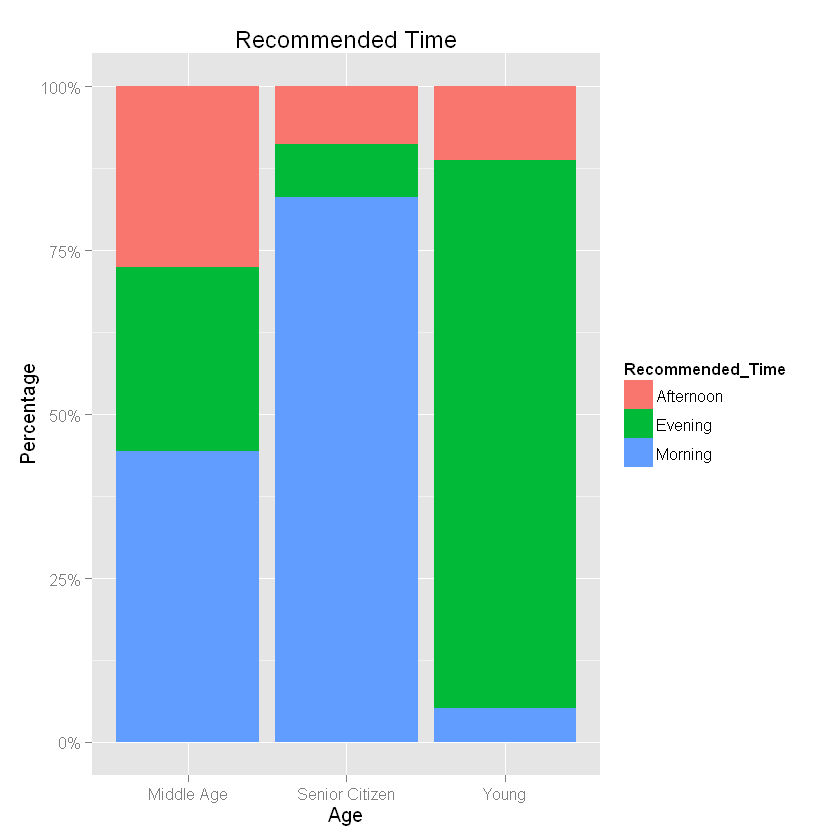

In [38]:
# Draw bar plots to visualize correlations 
Recommendations <- RxSqlServerData(table = "Recommendations", stringsAsFactors = T, connectionString = connection_string)
Rec <- rxImport(Recommendations)

## Recommended Time
pt <- table(Rec$`Recommended_Time`, Rec$Age)
datat <- melt(pt)
colnames(datat) <- c("Recommended_Time", "Age", "Percentage")

ggplot(datat, aes(x = Age ,y = Percentage, fill =`Recommended_Time`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Time")

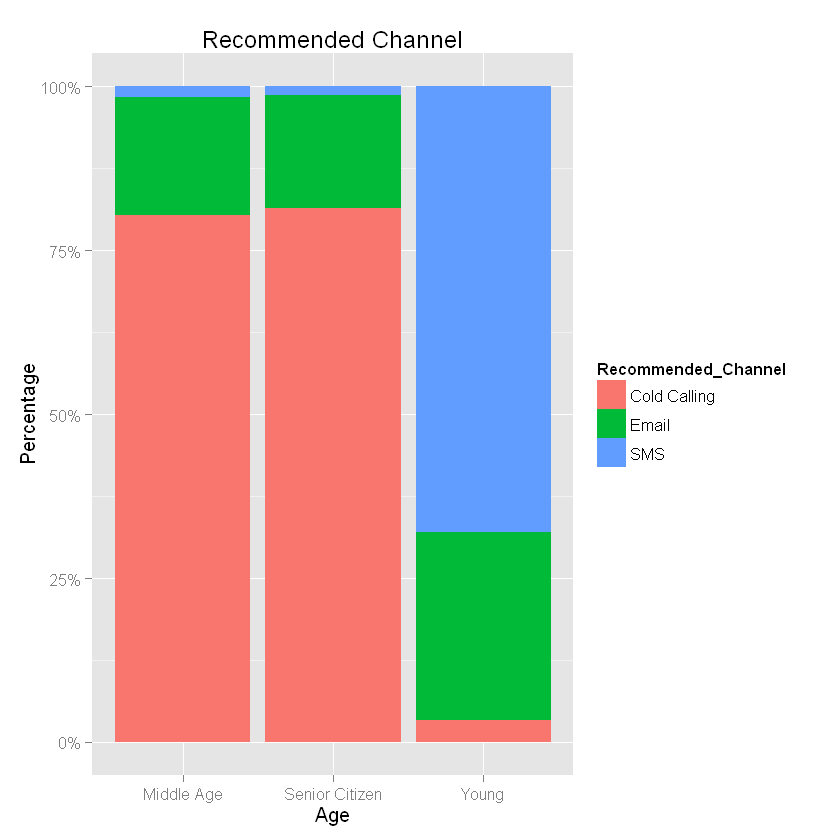

In [39]:
## Recommended Channel 
pc <- table(Rec$`Recommended_Channel`, Rec$Age)

datac <- melt(pc)
colnames(datac) <- c("Recommended_Channel", "Age", "Percentage")

ggplot(datac, aes(x = Age ,y = Percentage, fill =`Recommended_Channel`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Channel")

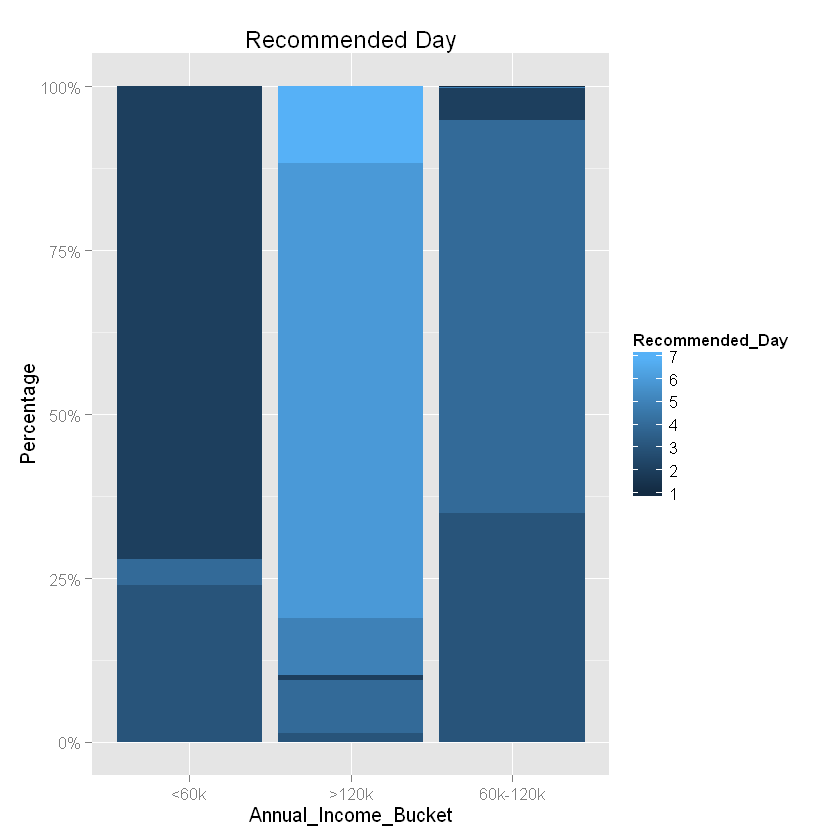

In [40]:
## Recommended Day 
pd <- table(Rec$`Recommended_Day`, Rec$Annual_Income_Bucket)

datad <- melt(pd)
colnames(datad) <- c("Recommended_Day", "Annual_Income_Bucket", "Percentage")

ggplot(datad, aes(x = Annual_Income_Bucket ,y = Percentage, fill =`Recommended_Day`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Day")